In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:

os.listdir(r'Data\World Bank')

In [ ]:
FDI_PATH = r'Data\World Bank\FDI_net_inflows_pct_gdp.xls'

WORLD_BANK_PATHS = [r'Data\World Bank\FDI_net_inflows_pct_gdp.xls',
                    r'Data\World Bank\exports_goods_services_pct_gdp.xls',
                    # r'Data\World Bank\FDI_net_inflows.xls',
                    r'Data\World Bank\GDP_per_capita_USD.xls',
                    r'Data\World Bank\gini.xls',
                    # r'Data\World Bank\government_expenditure_education_pct_gdp.xls',
                    r'Data\World Bank\government_expenditure_education_pct_total_expenditure.xls',
                    r'Data\World Bank\high_tech_exports.xls',
                    r'Data\World Bank\inflation_consumer_prices.xls',
                    r'Data\World Bank\internet_users_pct.xls',
                    r'Data\World Bank\R&D_expenditure_pct_gdp.xls',
                    r'Data\World Bank\R&D_researchers_per_million.xls',
                    r'Data\World Bank\scientific_journal_articles.xls',
                    r'Data\World Bank\unemployment_pct_labor_force.xls']

EU_COUNTRIES = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 
                'Cyprus', 'Czechia', 'Denmark', 'Estonia',
                'Finland', 'France', 'Germany', 'Greece',
                'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania',
                'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal',
                'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
                'European Union']


In [ ]:
os.chdir("Data\World Bank")

In [ ]:
WORLD_BANK_PATHS = os.listdir()
WORLD_BANK_PATHS

In [ ]:
world_bank_df = pd.read_excel(WORLD_BANK_PATHS[0], skiprows=3)
for path in WORLD_BANK_PATHS[1:]:
    df = pd.read_excel(path, skiprows=3)
    world_bank_df = pd.concat([world_bank_df, df])

world_bank_df = world_bank_df[world_bank_df["Country Name"].isin(EU_COUNTRIES)]
world_bank_df

In [ ]:
indicators = set(world_bank_df["Indicator Name"].values)
indicators

In [200]:
def to_timeseries(df, indicator, country, lower_range=2004, upper_range=2022, EU=False):
    df = df[df["Indicator Name"] == indicator]
    if not EU:
        df = df[df["Country Name"] == country]
    else:
        df = df[df["Country Name"] != country]
        
    years, values = [], []

    for year in range(lower_range, upper_range+1):
        years.append(year)
        if not EU:
            values.append(df[str(year)].iloc[0])
        else:
            values.append(np.mean(df[str(year)]))

    return years, values
    

In [ ]:
years, poland_fdi = to_timeseries(world_bank_df, 
                           indicator='Foreign direct investment, net inflows (% of GDP)',
                           country="Poland")
_ , europe_fdi = to_timeseries(world_bank_df,
                               indicator='Foreign direct investment, net inflows (% of GDP)',
                               country="European Union")

# europe_fdi = [i / (len(EU_COUNTRIES)-1) for i in europe_fdi]

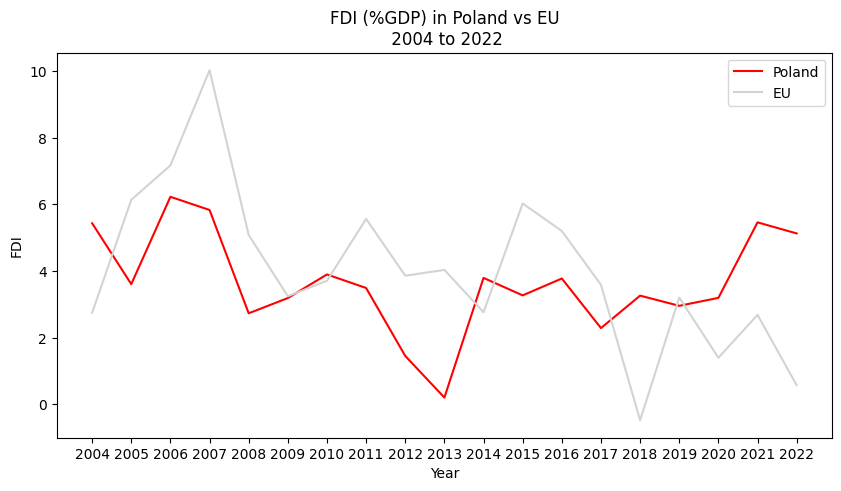

In [139]:
plt.figure(figsize=(10,5))
plt.plot(years, poland_fdi, c="red", label="Poland")
plt.plot(years, europe_fdi, c='lightgray', label="EU")
plt.title("FDI (%GDP) in Poland vs EU\n 2004 to 2022")
plt.xticks(years)
plt.xlabel("Year")
plt.ylabel("FDI")
plt.legend()
plt.show()

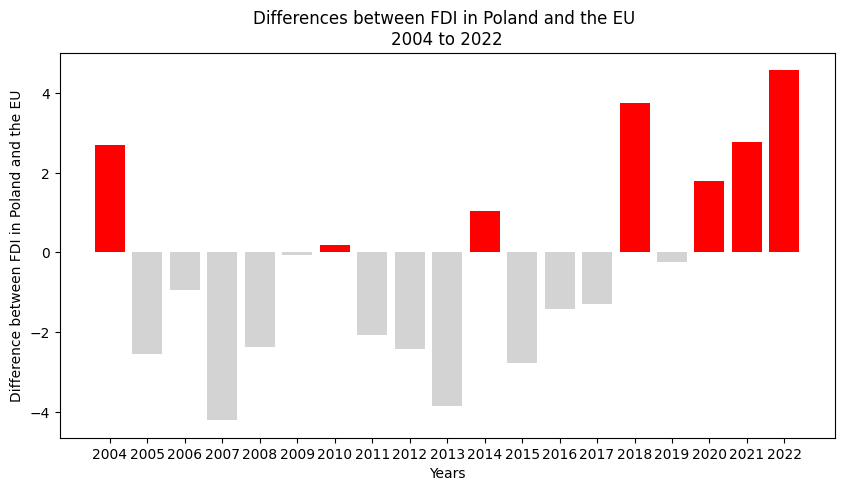

In [135]:
fdi_residuals = [p - e for p, e in zip(poland_fdi, europe_fdi)]
# plt.plot(years, fdi_residuals)

colors = ['red' if value > 0 else 'lightgray' for value in fdi_residuals]
plt.figure(figsize=(10,5))
plt.bar(years, fdi_residuals, color=colors)
plt.title("Differences between FDI in Poland and the EU \n2004 to 2022")
plt.xticks(years)
plt.xlabel("Years")
plt.ylabel("Difference between FDI in Poland and the EU")
plt.show()

In [ ]:
world_bank_df  = world_bank_df.drop(columns=["Country Code", "Indicator Code"])

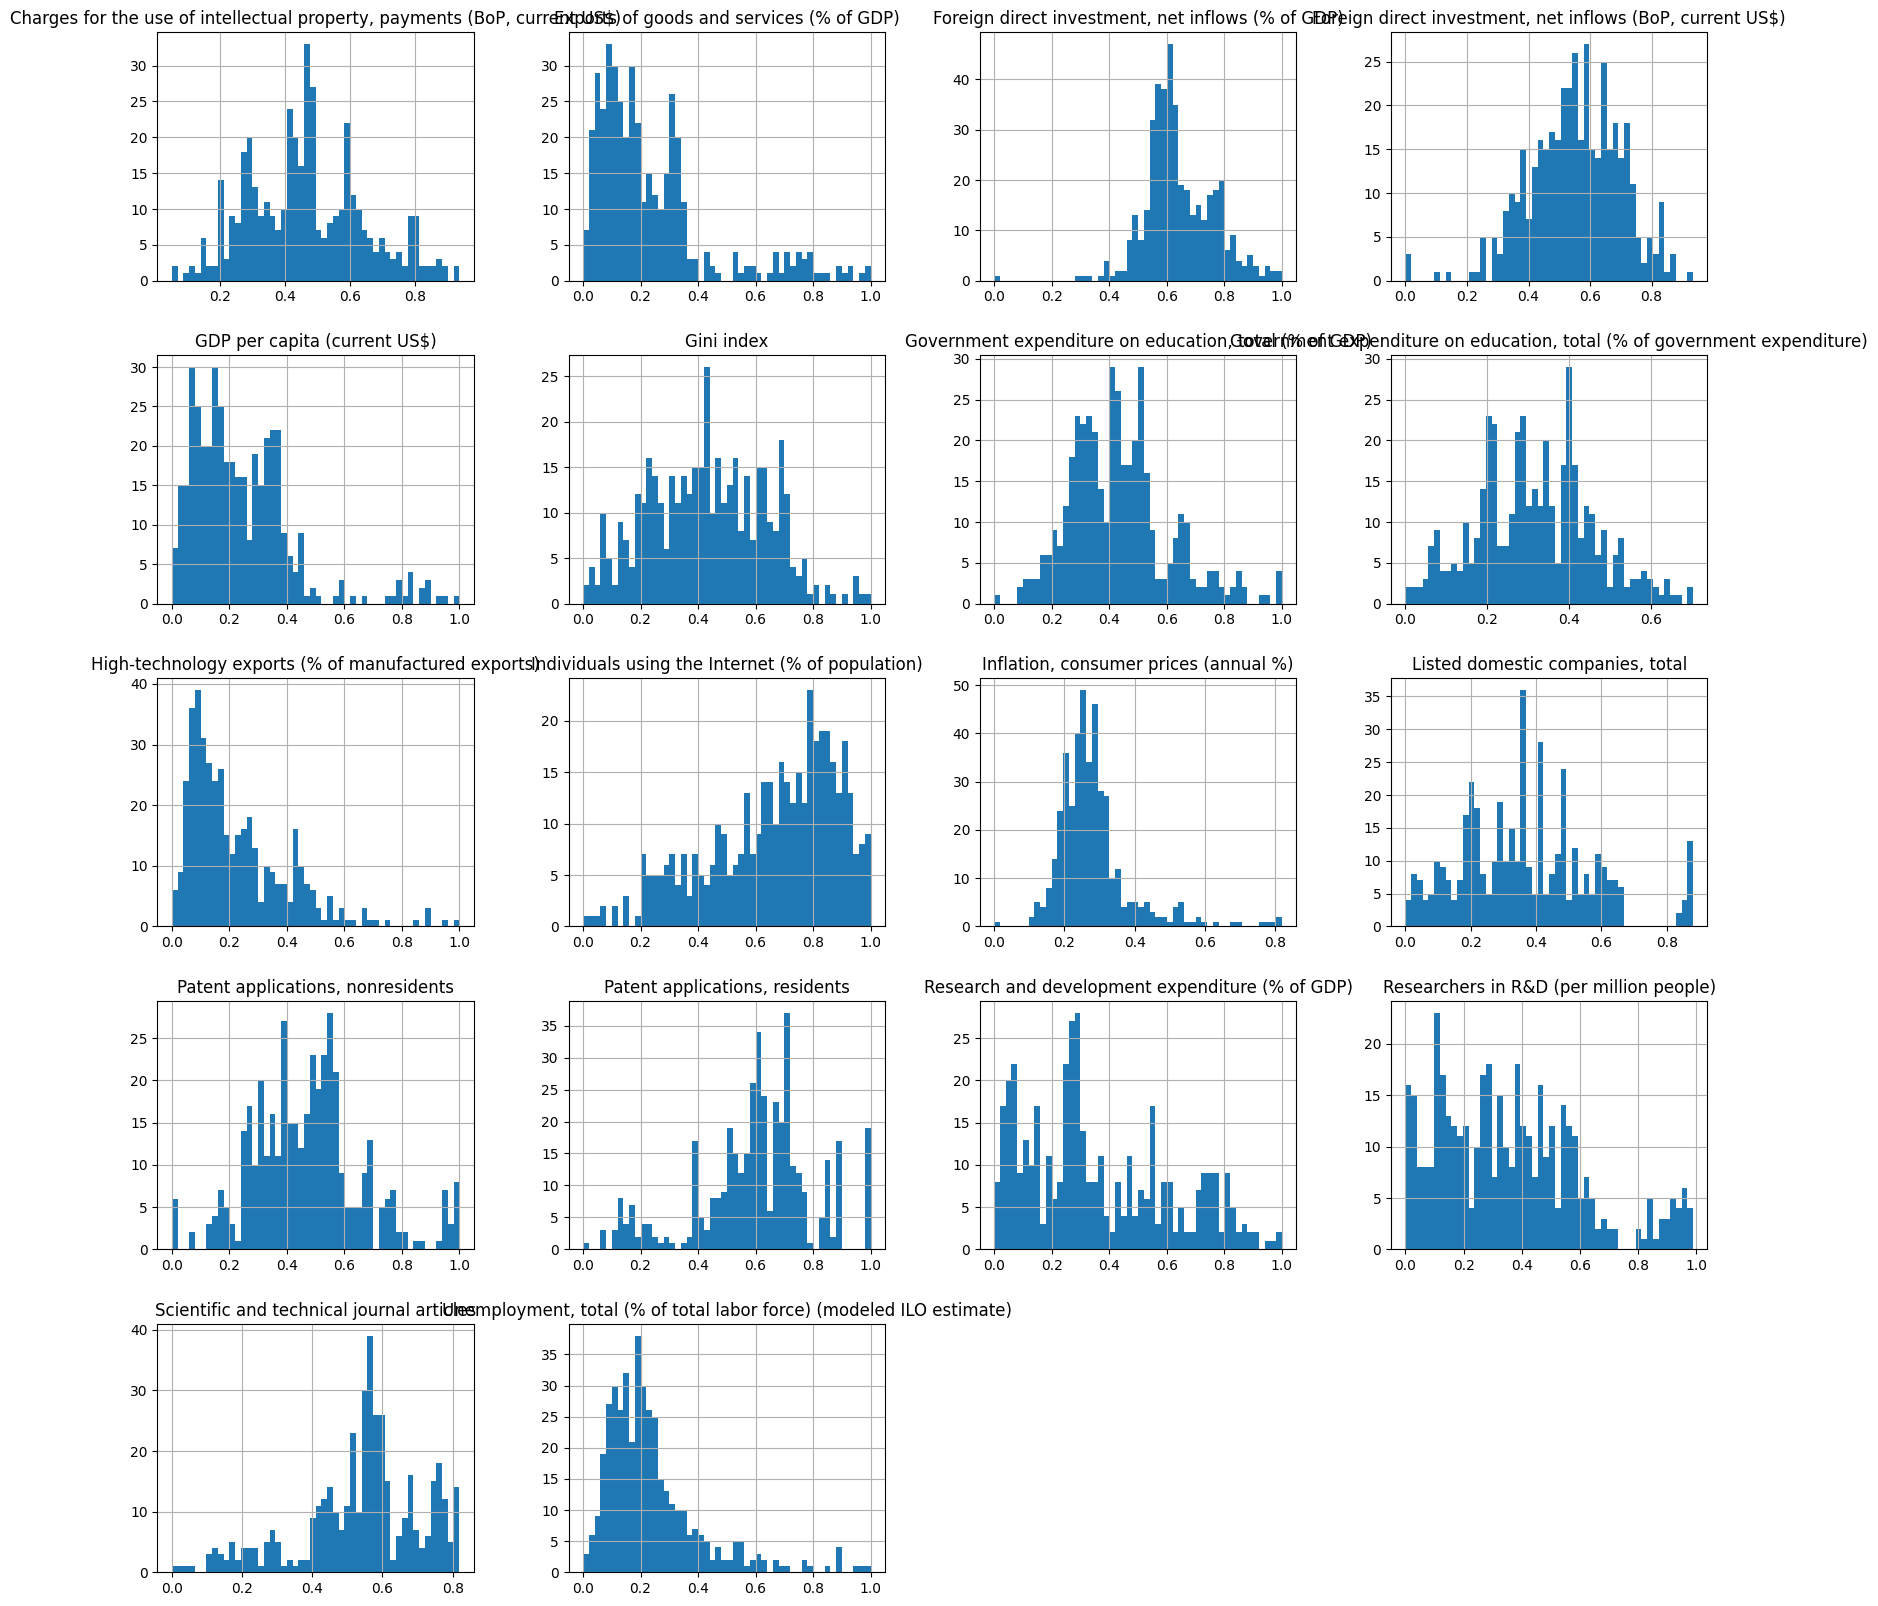

In [120]:
agg_df_2 = pd.melt(world_bank_df, id_vars=["Country Name", "Indicator Name"], var_name="Year", value_name="Value")
agg_df_2["Year"] = agg_df_2["Year"].astype(int)
agg_df_2 = agg_df_2[agg_df_2["Year"]>= 2004]
agg_df_2 = agg_df_2.pivot_table(index=["Country Name", "Year"], columns="Indicator Name", values="Value")

norm_df = agg_df_2.copy(deep=True)
norm_df["Charges for the use of intellectual property, payments (BoP, current US$)"] = norm_df["Charges for the use of intellectual property, payments (BoP, current US$)"] / norm_df["GDP per capita (current US$)"]

norm_df['Patent applications, nonresidents'] = np.log(agg_df_2["Patent applications, nonresidents"])
norm_df['Patent applications, residents'] = np.log(agg_df_2["Patent applications, residents"])
norm_df['Listed domestic companies, total'] = np.log(agg_df_2["Listed domestic companies, total"])
norm_df['Scientific and technical journal articles'] = np.log(agg_df_2["Scientific and technical journal articles"])
norm_df["Charges for the use of intellectual property, payments (BoP, current US$)"] = np.log(agg_df_2["Charges for the use of intellectual property, payments (BoP, current US$)"])
norm_df["Foreign direct investment, net inflows (% of GDP)"] = np.log(agg_df_2["Foreign direct investment, net inflows (% of GDP)"])
norm_df["Foreign direct investment, net inflows (BoP, current US$)"] = np.log(agg_df_2["Foreign direct investment, net inflows (BoP, current US$)"])

cols = norm_df.columns.tolist()

means = norm_df[cols].mean()
stds = norm_df[cols].std()

maxs = norm_df[cols].max()
mins = norm_df[cols].min()

# standardized_df = (norm_df[cols] - means) / stds
standardized_df = (norm_df[cols] - mins) / (maxs-mins)

norm_df[cols] = standardized_df

norm_df[cols] = norm_df.groupby('Country Name')[cols].transform(lambda x: x.fillna(x.mean()))
norm_df.dropna(axis=0, inplace=True)
norm_df.hist(figsize=(20,20), bins=50)
plt.show()

In [145]:
from linearmodels.panel import PanelOLS
# norm_df['Year'] = norm_df['Year'].astype(int)
dependent_variable = 'Foreign direct investment, net inflows (% of GDP)'
independent_variables = ['Charges for the use of intellectual property, payments (BoP, current US$)',
       'Exports of goods and services (% of GDP)',
       # 'Foreign direct investment, net inflows (% of GDP)',
       # 'Foreign direct investment, net inflows (BoP, current US$)',
       'GDP per capita (current US$)', 'Gini index',
       'Government expenditure on education, total (% of GDP)',
       'Government expenditure on education, total (% of government expenditure)',
       'High-technology exports (% of manufactured exports)',
       'Individuals using the Internet (% of population)',
       'Inflation, consumer prices (annual %)',
       'Listed domestic companies, total', 'Patent applications, nonresidents',
       'Patent applications, residents',
       'Research and development expenditure (% of GDP)',
       'Researchers in R&D (per million people)',
       'Scientific and technical journal articles',
       'Unemployment, total (% of total labor force) (modeled ILO estimate)']

# Create a model
model = PanelOLS(norm_df[dependent_variable], norm_df[independent_variables], entity_effects=False, time_effects=False)

# Fit the model
results = model.fit()

# Display regression results
print(results)


                                          PanelOLS Estimation Summary                                          
Dep. Variable:     Foreign direct investment, net inflows (% of GDP)   R-squared:                        0.9778
Estimator:                                                  PanelOLS   R-squared (Between):              0.9940
No. Observations:                                                418   R-squared (Within):              -0.4471
Date:                                               Sun, Mar 03 2024   R-squared (Overall):              0.9778
Time:                                                       19:24:53   Log-likelihood                    381.07
Cov. Estimator:                                           Unadjusted                                           
                                                                       F-statistic:                      1106.2
Entities:                                                         22   P-value                          

In [159]:
df = pd.DataFrame(data=[results._var_names, results.params, results.std_errors, results.pvalues])
df = df.transpose()
df.columns = ["Variable", "Coefficient", "STD Error", "P-value"]
df.set_index("Variable", inplace=True)
df.to_csv("data.csv")


In [122]:
norm_df_copy = norm_df.copy(deep=True)

try:
    norm_df_copy.dropna(inplace=True)
    norm_df_copy.reset_index(inplace=True)
    norm_df_copy = norm_df_copy.drop("Indicator Name", axis=1)
except:
    print("index already reset")
window_size = 5
first_year = 2004
mse = []

countries = set(norm_df_copy["Country Name"].values)
n_countries = len(countries)


for start in range(2004,  2023-window_size):
    end = start + window_size
    window_data = norm_df_copy[(start <= norm_df_copy["Year"]) & (norm_df_copy["Year"] <= end)]
    window_data.set_index(["Country Name", "Year"], inplace=True)

    # Estimate the model for the current window
    window_model = PanelOLS(window_data[dependent_variable], window_data[independent_variables]).fit()
    y_pred = window_model.predict(window_data[independent_variables])

    se = 0
    for country in countries:
            prediction = y_pred.loc[(country, end)]["predictions"]
            se += np.square(prediction - norm_df.loc[(country, end)][dependent_variable])
            norm_df_copy.set_index(["Country Name", "Year"], inplace=True)
            norm_df_copy.loc[(country, end)][dependent_variable] = prediction
            # print(prediction)
            # print(norm_df_copy.loc[(country, end)][dependent_variable])
            norm_df_copy.reset_index(inplace=True)
    
    mse.append(se/n_countries)

mse, n_countries

index already reset


([0.009710349347238738,
  0.005135988246108192,
  0.007160731460703299,
  0.02792732872997823,
  0.017356354159068766,
  0.015712546992481764,
  0.011477458419088643,
  0.003522909633871489,
  0.0042959106730147256,
  0.003671703177209236,
  0.0075063001893433704,
  0.007219104660098594,
  0.00399118340241949,
  0.003801737225622111],
 22)

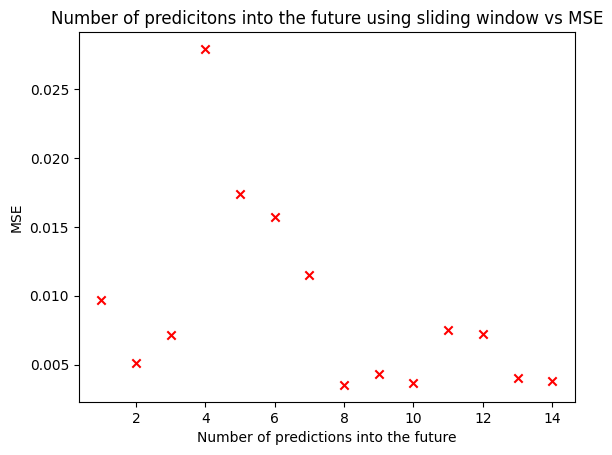

In [142]:
plt.scatter(range(1, len(mse) +1), mse, c="Red", marker="x")
plt.title("Number of predicitons into the future using sliding window vs MSE")
plt.xlabel("Number of predictions into the future")
plt.ylabel("MSE")
plt.show()

In [124]:
import shap
import sklearn

# X, y = shap.datasets.california(n_points=1000)
X = norm_df[independent_variables]
y = norm_df[dependent_variable].values 
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)


LinearRegression()

PermutationExplainer explainer: 419it [00:27, 10.38it/s]                         


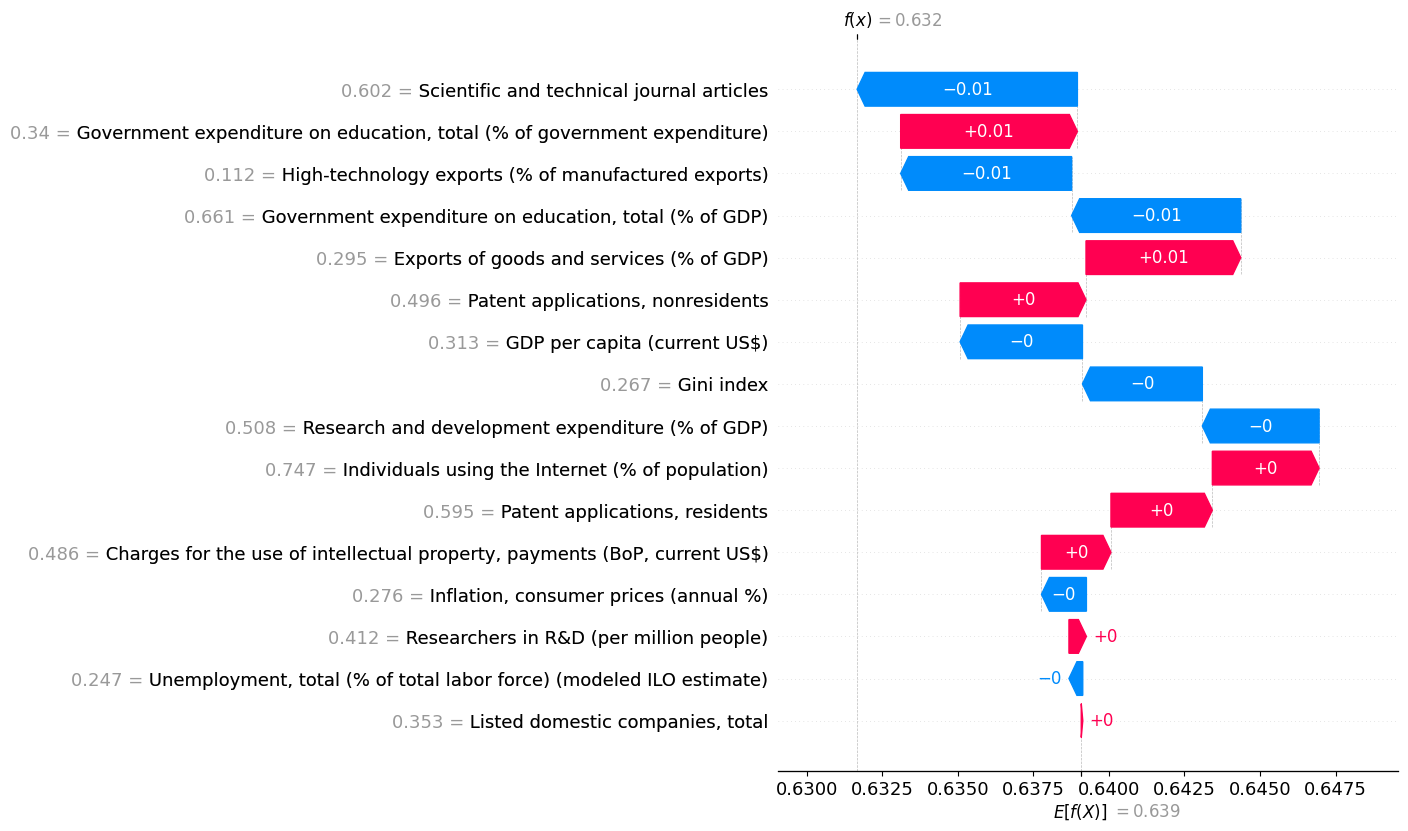

In [125]:
import warnings
warnings.filterwarnings('ignore')
# X100 = shap.utils.sample(X, 100) 

explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[25], max_display=16)

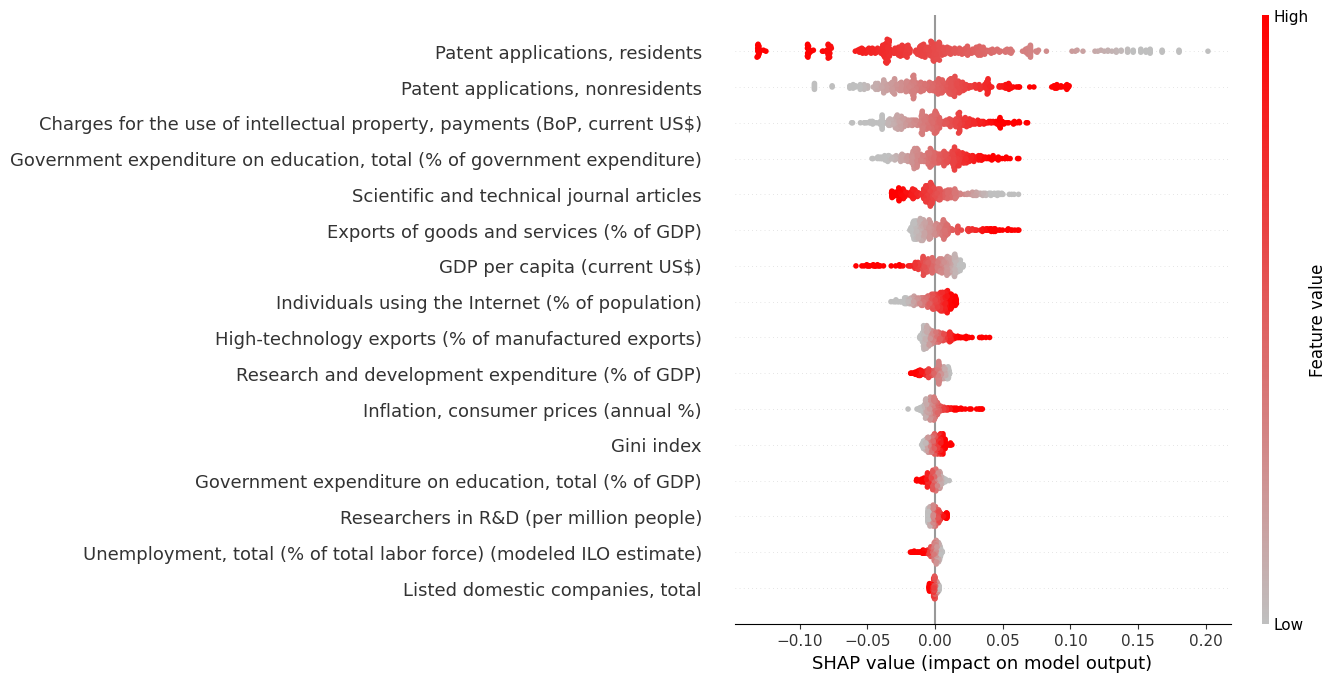

In [138]:
from matplotlib.colors import LinearSegmentedColormap
color_gradient = [(0.75, 0.75, 0.75), (1.0, 0.0, 0.0)]  # (R, G, B)
custom_cmap = LinearSegmentedColormap.from_list('gray_to_red', color_gradient, N=256)

# shap.plots.beeswarm(shap_values, max_display=16, color=plt.get_cmap("Reds"))
shap.plots.beeswarm(shap_values, max_display=16, color=custom_cmap)

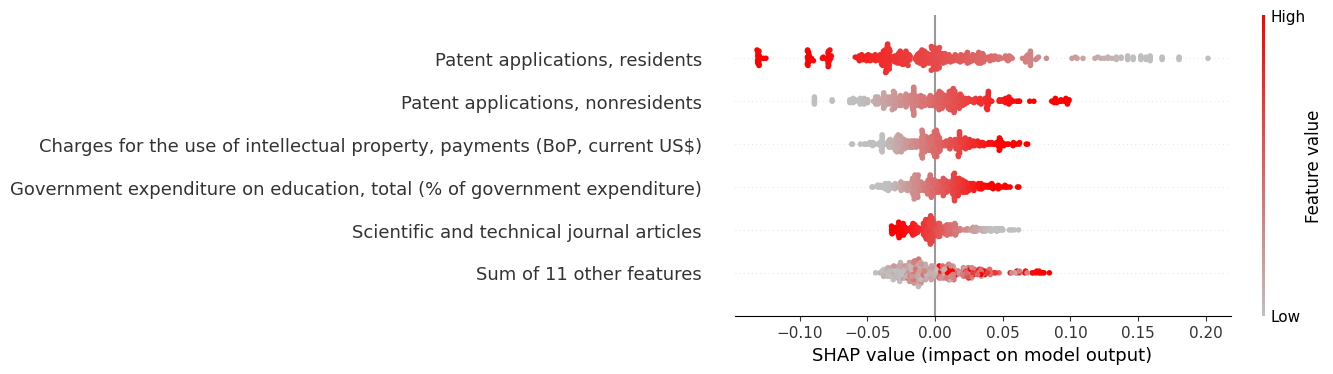

In [161]:
shap.plots.beeswarm(shap_values, max_display=6, color=custom_cmap)

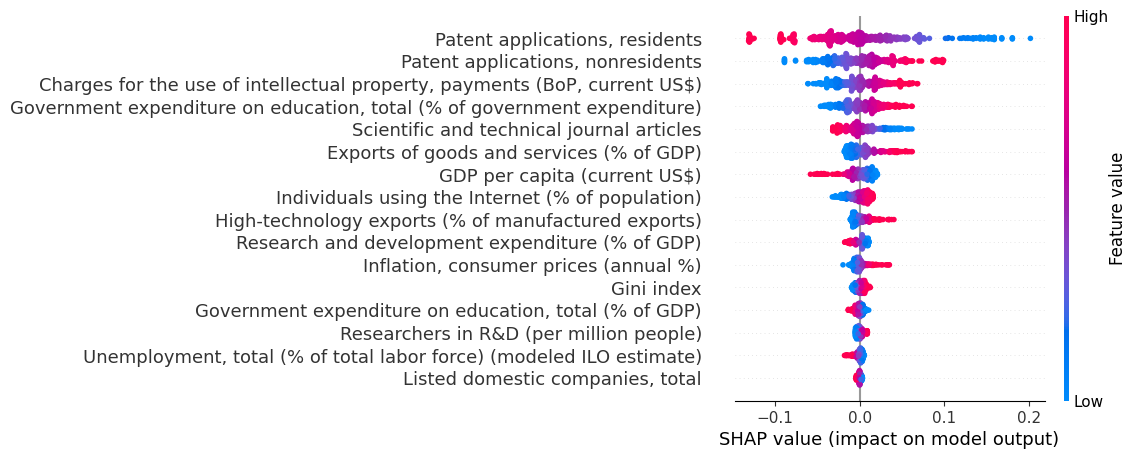

In [165]:
shap.summary_plot(shap_values, plot_size=(5,5), color=custom_cmap)


In [169]:
set(world_bank_df["Indicator Name"])

{'Charges for the use of intellectual property, payments (BoP, current US$)',
 'Exports of goods and services (% of GDP)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Foreign direct investment, net inflows (BoP, current US$)',
 'GDP per capita (current US$)',
 'Gini index',
 'Government expenditure on education, total (% of GDP)',
 'Government expenditure on education, total (% of government expenditure)',
 'High-technology exports (% of manufactured exports)',
 'Individuals using the Internet (% of population)',
 'Inflation, consumer prices (annual %)',
 'Listed domestic companies, total',
 'Patent applications, nonresidents',
 'Patent applications, residents',
 'Research and development expenditure (% of GDP)',
 'Researchers in R&D (per million people)',
 'Scientific and technical journal articles',
 'Unemployment, total (% of total labor force) (modeled ILO estimate)'}

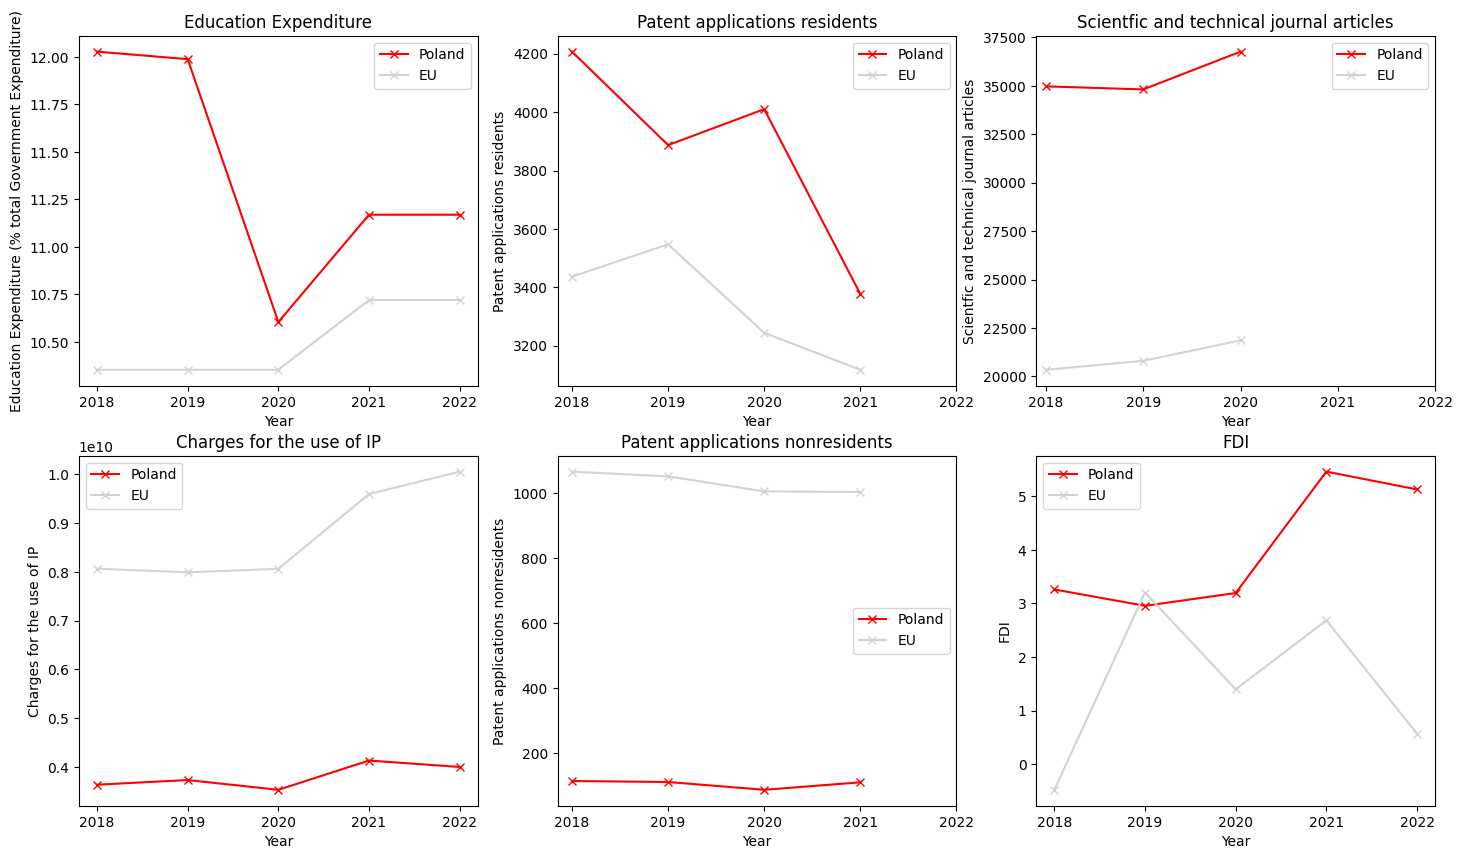

In [214]:
years, education_poland = to_timeseries(world_bank_df, "Government expenditure on education, total (% of government expenditure)", "Poland", 2018, 2022)
_, education_eu = to_timeseries(world_bank_df, "Government expenditure on education, total (% of government expenditure)", "European Union", 2018, 2022)
education_poland = education_poland[:4] + [education_poland[3]]
education_eu = [education_eu[2], education_eu[2]] + education_eu[2:4] +[education_eu[3]]

_, pres_poland = to_timeseries(world_bank_df,  'Patent applications, residents', "Poland", 2018, 2022)
_, pres_eu = to_timeseries(world_bank_df,  'Patent applications, residents', "European Union", 2018, 2022, True)

_, pnres_poland = to_timeseries(world_bank_df,  'Patent applications, nonresidents', "Poland", 2018, 2022)
_, pnres_eu = to_timeseries(world_bank_df,  'Patent applications, nonresidents', "European Union", 2018, 2022, True)


_, ip_poland = to_timeseries(world_bank_df,  'Charges for the use of intellectual property, payments (BoP, current US$)', "Poland", 2018, 2022)
_, ip_eu = to_timeseries(world_bank_df,  'Charges for the use of intellectual property, payments (BoP, current US$)', "European Union", 2018, 2022, True)

_, fdi_poland = to_timeseries(world_bank_df,  'Foreign direct investment, net inflows (% of GDP)', "Poland", 2018, 2022)
_, fdi_eu = to_timeseries(world_bank_df,  'Foreign direct investment, net inflows (% of GDP)', "European Union", 2018, 2022)

_, sci_poland = to_timeseries(world_bank_df,  'Scientific and technical journal articles', "Poland", 2018, 2022)
_, sci_eu = to_timeseries(world_bank_df,  'Scientific and technical journal articles', "European Union", 2018, 2022, True)

fig, axs = plt.subplots(2,3, figsize=(17.5,10))
# plt.figure()

axs[0, 0].plot(years, education_poland, c="red", label="Poland", marker="x")
axs[0, 0].plot(years, education_eu, c='lightgray', label="EU",  marker="x")
axs[0, 0].set_title("Education Expenditure")
axs[0, 0].set_xticks(years)
axs[0, 0].set_xlabel("Year")
axs[0, 0].set_ylabel("Education Expenditure (% total Government Expenditure)")
axs[0, 0].legend()

axs[0, 1].plot(years, pres_poland, c="red", label="Poland", marker="x")
axs[0, 1].plot(years, pres_eu, c='lightgray', label="EU",  marker="x")
axs[0, 1].set_title("Patent applications residents")
axs[0, 1].set_xticks(years)
axs[0, 1].set_xlabel("Year")
axs[0, 1].set_ylabel("Patent applications residents")
axs[0, 1].legend()

axs[1, 0].plot(years, ip_poland, c="red", label="Poland", marker="x")
axs[1, 0].plot(years, ip_eu, c='lightgray', label="EU",  marker="x")
axs[1, 0].set_title("Charges for the use of IP")
axs[1, 0].set_xticks(years)
axs[1, 0].set_xlabel("Year")
axs[1, 0].set_ylabel("Charges for the use of IP")
axs[1, 0].legend()

axs[1, 1].plot(years, pnres_poland, c="red", label="Poland", marker="x")
axs[1, 1].plot(years, pnres_eu, c='lightgray', label="EU",  marker="x")
axs[1, 1].set_title("Patent applications nonresidents")
axs[1, 1].set_xticks(years)
axs[1, 1].set_xlabel("Year")
axs[1, 1].set_ylabel("Patent applications nonresidents")
axs[1, 1].legend()

axs[0, 2].plot(years, sci_poland, c="red", label="Poland", marker="x")
axs[0, 2].plot(years, sci_eu, c='lightgray', label="EU",  marker="x")
axs[0, 2].set_title("Scientfic and technical journal articles")
axs[0, 2].set_xticks(years)
axs[0, 2].set_xlabel("Year")
axs[0, 2].set_ylabel("Scientfic and technical journal articles")
axs[0, 2].legend()

axs[1, 2].plot(years, fdi_poland, c="red", label="Poland", marker="x")
axs[1, 2].plot(years, fdi_eu, c='lightgray', label="EU",  marker="x")
axs[1, 2].set_title("FDI")
axs[1, 2].set_xticks(years)
axs[1, 2].set_xlabel("Year")
axs[1, 2].set_ylabel("FDI")
axs[1, 2].legend()



plt.show()


In [191]:
np.array(ip_eu) / 27

array([7.49656278e+09, 7.72276077e+09, 7.78900911e+09, 9.26711071e+09])

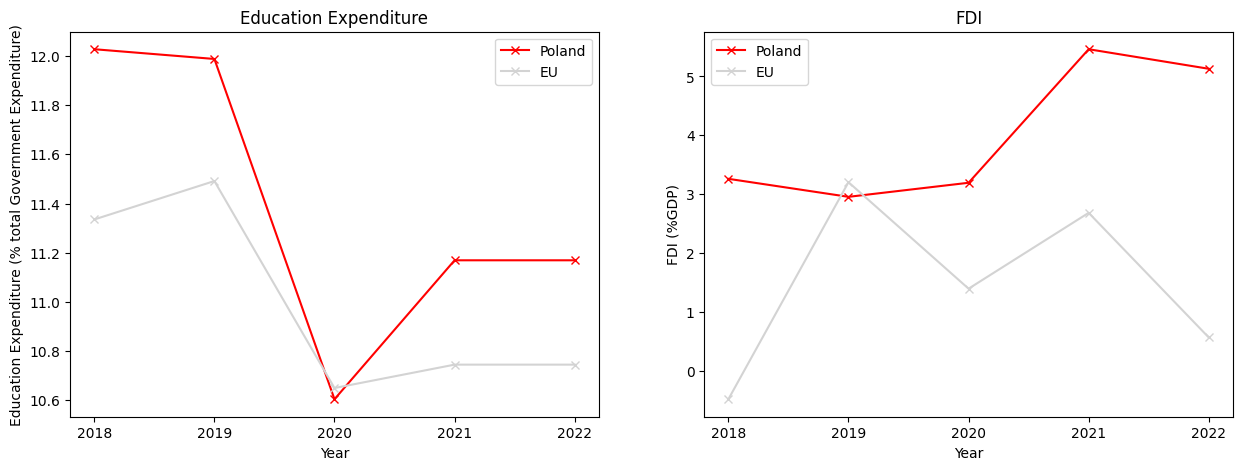

In [224]:

years, education_poland = to_timeseries(world_bank_df, "Government expenditure on education, total (% of government expenditure)", "Poland", 2018, 2022)
_, education_eu = to_timeseries(world_bank_df, "Government expenditure on education, total (% of government expenditure)", "European Union", 2018, 2022, True)
education_poland = education_poland[:4] + [education_poland[3]]
education_eu = education_eu[:4] + [education_eu[3]]
fig, axs = plt.subplots(1,2, figsize=(15,5))
# plt.figure()

axs[0].plot(years, education_poland, c="red", label="Poland", marker="x")
axs[0].plot(years, education_eu, c='lightgray', label="EU",  marker="x")
axs[0].set_title("Education Expenditure")
axs[0].set_xticks(years)
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Education Expenditure (% total Government Expenditure)")
axs[0].legend()


axs[1].plot(years, fdi_poland, c="red", label="Poland", marker="x")
axs[1].plot(years, fdi_eu, c='lightgray', label="EU",  marker="x")
axs[1].set_title("FDI")
axs[1].set_xticks(years)
axs[1].set_xlabel("Year")
axs[1].set_ylabel("FDI (%GDP)")
axs[1].legend()


# fig.set_title("Education Expenditure and FDI in Poland and EU from 2018 to 2022")
plt.show()